from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('monokai')

# **Loan Default Prediction**

by: Moiez Ismail

#### Table of contents: 
- [Data overview](#Data-overview)
- [Insights from EDA](#Insights-from-EDA)
- [Model data prep](#Model-data-prep)
- [Model evaluation criterion](#Model-evaluation-criterion)
- [Model comparison and conclusion](#Model-conclusion)
- [Executive summary](#Executive-summary)

## Context
Global Bank (GB) derives profit from interest on loans but faces risks when clients default on their loans (DL). Not every loan that is approved is paid off (GL), and the loan approval process is crucial to minimize defaults and maximize good loans. The bank's decision-making on loan approvals, based on various factors, is not infallible and is subject to human error. To mitigate this, GB is implementing a machine-learning model to assist in the loan approval process.

## Objective
The project aims to develop a machine-learning model capable of predicting loan defaults and pay-offs, providing GB with insights on critical features that should be considered in the loan approval process.

## Key Questions
- What factors are most indicative of a client's likelihood to default?
- Is there a notable difference in certain features between clients who default and those who do not?
- What additional features could enhance the model's explanatory and predictive capabilities?

## Problem Formulation
The task is a binary classification problem focusing on accurately predicting actual defaults (DL) and minimizing false negatives (clients predicted as GL but turn out to be DL).

Also see for further details : - [Model evaluation criterion](#Model-evaluation-criterion)


## Data description
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property. 

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts) 

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments). 

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due). 

* **CLAGE:** Age of the oldest credit line in months. 

* **NINQ:** Number of recent credit inquiries. 

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

## **Import the necessary libraries and data**

In [8]:
import plotly.io as pio
pio.renderers.default = "svg"
import pandas as pd
import uuid
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import skew, pearsonr, normaltest, ttest_ind, f_oneway, chisquare, chi2_contingency, shapiro
import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC

### **Model data prep**
1. Data preparation (create 2 datasets for model to compare performance)
2. Partition the data into train and test set (scale the data for logistic regression)
3. Build the model (base models of Logistic Regression, Decision Trees + Random forest)
4. Fit on the train data
5. Tune the model (Gridsearch CV utilized)
6. Test the model on test set

In [10]:
# data import
data = pd.read_csv("cleaned_loan.csv")
loan = data.copy()

In [11]:
# Convert categorical variables to numerical using one-hot encoding for both datasets
loan = pd.get_dummies(loan, columns=['REASON', 'JOB'])

In [12]:
# creating the target variable and taking it out of the independent variable dataframe
y = loan['BAD']
X = loan.drop(columns=['BAD', 'Status'], axis=1) #also dropping the status variable to avoid colinearity 
#Splitting the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# Scaling the data
sc = StandardScaler()
scaledXtrain = sc.fit_transform(X_train)
scaledXtest = sc.transform(X_test)


In [14]:
# Turning the scaled train and test data into a datarame
scaledXtrain = pd.DataFrame(scaledXtrain, columns=X_train.columns)
scaledXtest = pd.DataFrame(scaledXtest, columns=X_test.columns)

## Model evaluation criterion

**Model can make wrong predictions as**:

1. Case 1(Type 2 error): Predicting a client will pay off their loan as expected to but actually defaults = False negative(FN) where prediction = 0 but actually 1 
2. Case 2(Type 1 error): Predicting a client will default but actually does not do so = False positive(FP) predict = 1 but actually 0

### Which case is more important?

**Case 1: Predicting that the client will NOT default but actually does** i.e. a false negative can result in the bank approving a loan to a client who is going to default resulting loss of money. A false positive is not as deterimental as the bank may reject a loan to a client who will eventually pay it off resulting in profit, but this is not as costly as the former case. 

### How to reduce the losses?

**maximize Recall** : when recall is maximized, then false negatives are minimized, which results in highest number of predicting DL and thus predicting which clients will be GL.  In a case where both approving GL results in profit, and rejecting DL avoids loss of profit then a balance of recall and precision, the losses can be mitigated by approving loans to good clients as that will balance out the losses.  if the model can maximize predicting actual defaulting loans we can identify high-risk borrowers thus minimize giving out risky loans. 

### Function for printing out the evaluation of the model

In [17]:
def recall_matrix(model, xtrain, xtest, y_train, y_test):
    pred_train = model.predict(xtrain)
    pred_test = model.predict(xtest)
    
    train_recall_0 = recall_score(y_train, pred_train, pos_label=0)
    train_recall_1 = recall_score(y_train, pred_train, pos_label=1)
    test_recall_0 = recall_score(y_test, pred_test, pos_label=0)
    test_recall_1 = recall_score(y_test, pred_test, pos_label=1)

    # Print recall scores
    print("recall score on training set for 0: ", np.round(train_recall_0, 3))
    print("recall score on training set for 1: ", np.round(train_recall_1, 3))
    print("recall score on test set for 0: ", np.round(test_recall_0, 3))
    print("recall score on test set for 1: ", np.round(test_recall_1, 3))
    
    # Calculate confusion matrices
    cm_train = confusion_matrix(y_train, pred_train)
    cm_test = confusion_matrix(y_test, pred_test)

    # Plot confusion matrices as heatmaps
    plot_confusion_matrix(cm_train, 'Confusion Matrix for Training Data')
    plot_confusion_matrix(cm_test, 'Confusion Matrix for Test Data')

#### visualize the confusion matrix

In [19]:
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=['Good', 'Defaulted'],
                yticklabels=['Good', 'Defaulted'], cmap='RdBu', annot_kws={"fontsize": 14}, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

### **Building the model**
Due to the nature of the problem (binary Classification) identifying whethere or not someone will default:
1. Logistic Regression (LG hereafter)
2. Decision Trees (DT hereafter)
3. Random Forests (RF hereafter)
4. XG boost (XGB hereafter) 

### Logistic Regression

In [22]:
lg = LogisticRegression()
lg.fit(scaledXtrain, y_train)

LogisticRegression()

recall score on training set for 0:  0.975
recall score on training set for 1:  0.351
recall score on test set for 0:  0.967
recall score on test set for 1:  0.351


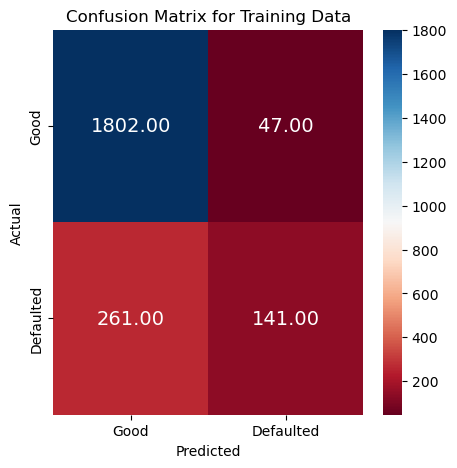

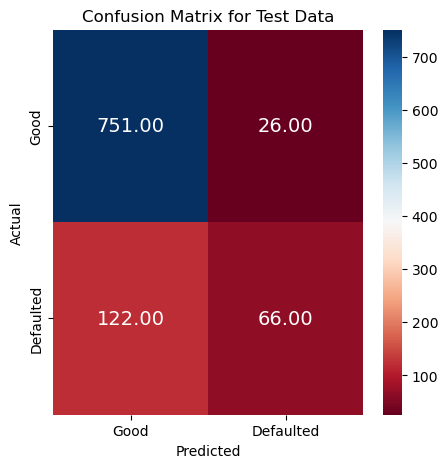

In [23]:
recall_matrix(lg, scaledXtrain, scaledXtest, y_train, y_test)

**Observation**
1. Both Loan1 and Loan2 models are doing a great job on the train and test data for identifying Good status clients, but doing a horrible job for the defaulting clients because 1= 0.085 for both models 

**Let's check the coefficients to see the variables contributing the most to defaulting on loans**

Since the coefficients are difficult to interpret, we will take the exponent of these logs to make sense of the features 

In [27]:
odds = np.exp(lg.coef_[0]) # Finding the odds

# Adding the odds to a DataFrame and sorting the values
np.round(pd.DataFrame(odds, X_train.columns, columns = ['odds']).sort_values(by = 'odds', ascending = False),3) 

,odds
DELINQ,2.550
DEROG,1.819
DEBTINC,1.635
NINQ,1.384
JOB_Sales,1.168
JOB_Self,1.123
YOJ,1.115
MORTDUE,1.100
JOB_ProfExe,1.089
JOB_Mgr,1.035


**Observations:**
1. The first 4 features in order of decreasing strength of correlation, DELINQ, DEBTINC, INCOME, and DEROG are all positively correlated with the odds of defaulting on a loan
2. For example, for every increase in 1 unit of DELINQ, the odds of defaulting on a loan increases by by 2.5x!

### Decision Tree

In [30]:
#Function for printing out feature importances:

def plot_feature_importance(model, X_train):
    feature_importances = pd.DataFrame(model.feature_importances_, 
                                       columns=["Importance"], 
                                       index=X_train.columns).sort_values(by='Importance', ascending=True)
    
    fig = px.bar(feature_importances,
                 x='Importance', y=feature_importances.index, 
                 orientation='h',
                 color='Importance', text='Importance', color_continuous_scale='purples',
                 labels={'x': 'Importance', 'y': 'Feature'}, title='Feature Importances',
                 width=800, height=600)
    fig.update_traces(texttemplate='%{text:.3f}', textposition='inside')
    fig.show()

In [31]:
dt = DTC(random_state=42)

dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

recall score on training set for 0:  1.0
recall score on training set for 1:  1.0
recall score on test set for 0:  0.934
recall score on test set for 1:  0.601


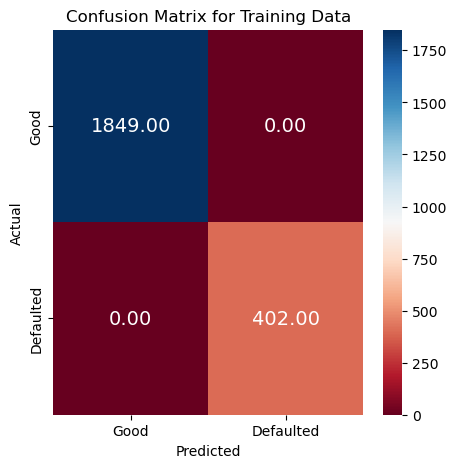

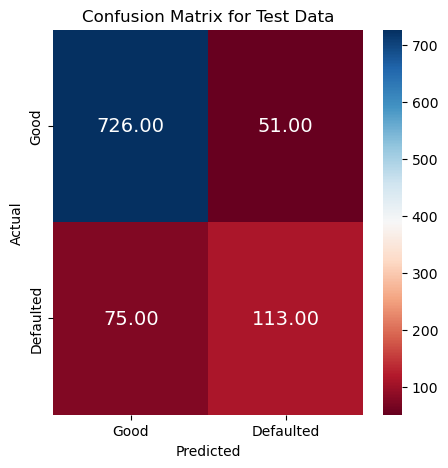

In [32]:
recall_matrix(dt, X_train, X_test, y_train, y_test)

**Observation** 
1. As expected, Both Loan 1 and 2 have the same recall score 
2. Training model : the model is over-fitting both Loan1 and Loan2 as the scores for recall at 100% 
2. Test data- we have just over 50% for both models which is still not great performance
3. We have to bring the number up for predicting actual 1s(defaulting on loans) even if it comes at a cost of reducing predicting actual negatives. Let's keep pushing by tuning the parameters

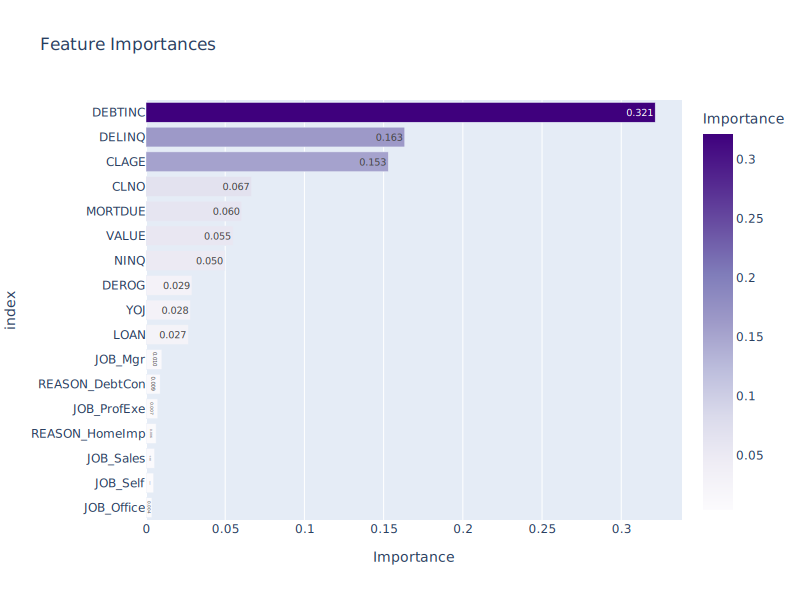

In [34]:
plot_feature_importance(dt, X_train)

**observations**
1. Unlike the LG model, DT is giving the most importance to DEBTINC, but now also considering age of oldest credit line. 
2. Let's see if it will be more or less balanced as we tune the hyperparameters. 

#### Hyperparameter Tuning:
1. Tune the random forest classifier using GridSearchCV
2. Check the performance on both training and testing datasets
3. Compare the results with the results from the base decision tree model

In [37]:
class_weights = {0: 0.2, 1: 0.8} # more weight for class 1

weighted_tree = DTC(class_weight=class_weights)

weighted_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8})

recall score on training set for 0:  1.0
recall score on training set for 1:  1.0
recall score on test set for 0:  0.934
recall score on test set for 1:  0.638


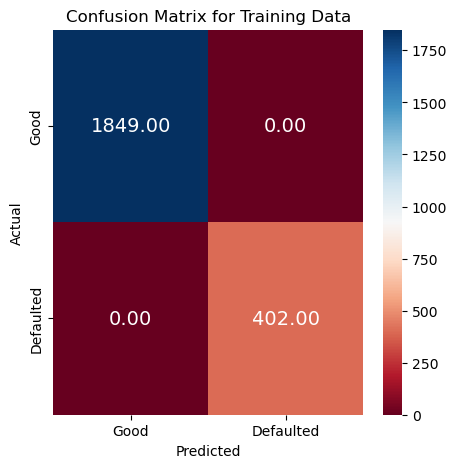

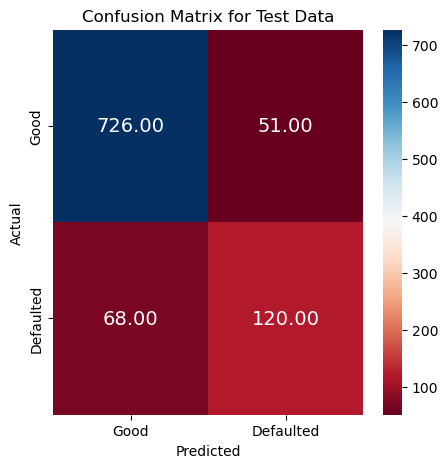

In [38]:
recall_matrix(weighted_tree, X_train, X_test, y_train, y_test)

**Observations**
1. These weighted trees are both doing better  than the base model. The model is still overfitting the training data as expected
2. All the models thus far are doing well for the test data on predicting actual Good loans but only just better than 50% on defaulting loans, not satisfied, let's keep pushing! 

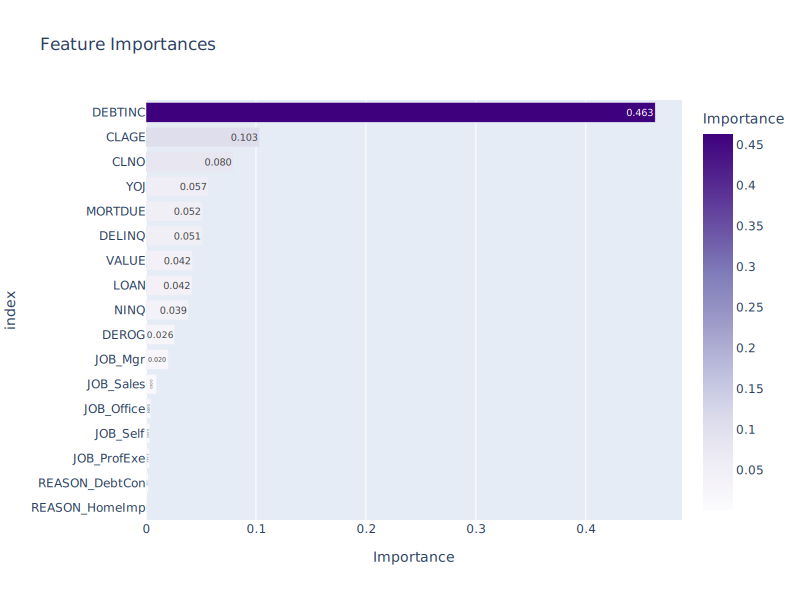

In [40]:
plot_feature_importance(weighted_tree, X_train)

**observations**
1. Still similar to the previous trees in importance but more importance now to DEBTINC but now more to YOJ as well

Let's tune the hyperparameters using Gridsearch Cross-validation to see if we can get better performance

In [43]:
parameters = {'max_depth': [3, 5, 7, 8],
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 15, 20, 25, 30],
              'min_samples_split': [10, 15, 20, 25, 30, 35, 40]}

grid_tuned_dt = DTC(class_weight=class_weights)
grid_search = GridSearchCV(grid_tuned_dt, parameters, cv=10, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

grid_tuned_dt = grid_search.best_estimator_

grid_tuned_dt.fit(X_train, y_train)

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 40}


DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=8,
                       min_samples_leaf=15, min_samples_split=40)

**Observations**
1. The gridsearch gave slightly different parameters

recall score on training set for 0:  0.858
recall score on training set for 1:  0.886
recall score on test set for 0:  0.838
recall score on test set for 1:  0.824


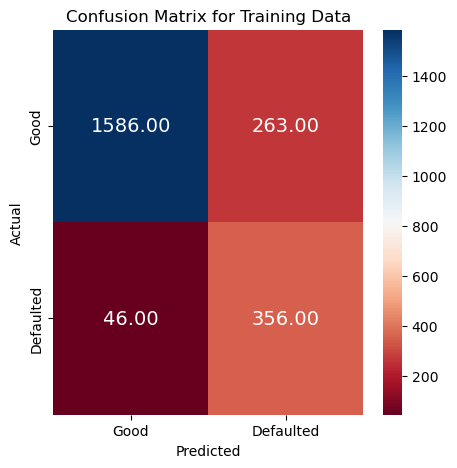

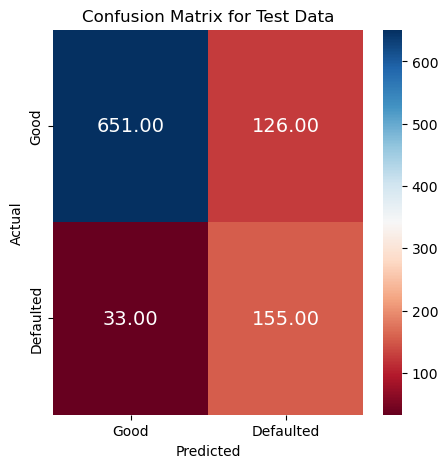

In [45]:
recall_matrix(grid_tuned_dt, X_train, X_test, y_train, y_test)

**Observations** 
1. Finally we have achieved a better recall for DL than GL, and both Loan1 and Loan2 have the same performance
2. It's interesting that an null-values imputed dataset is having the same performance as a dataset that dropped the nulls. 
3. at GL predicted correctly at 80% and DL at 85%, this model is the best so far, and deployment worthy. Tuned DT 1 hereafter

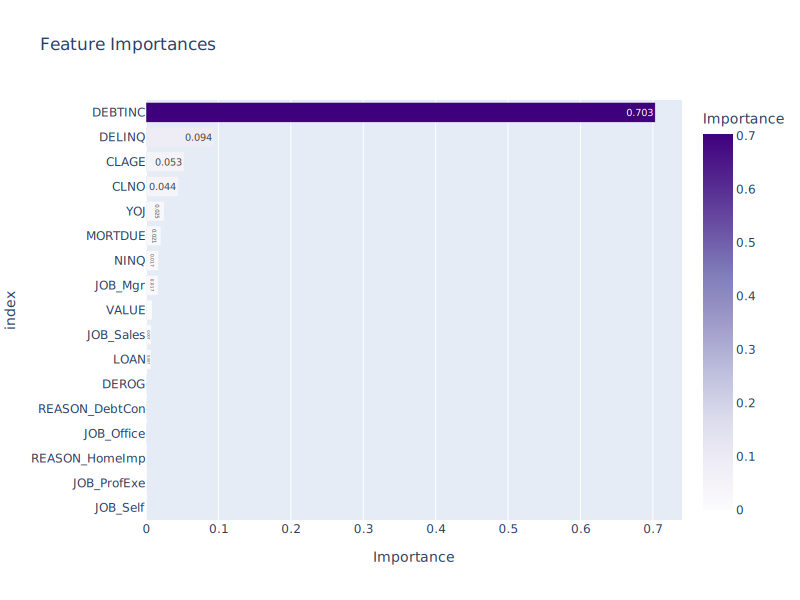

In [47]:
plot_feature_importance(grid_tuned_dt, X_train)

**Observations**
1. The tuned decision tree is giving even more importance to DEBTINC and now also to DELINQ
2. Interestingly, it's now giving importantce to age of oldest credit line and income but much less than the first 2 features

Let's try tuning the hyperparamters once again manually by reducing the depth, and samples in the leaf and split

In [50]:
final_DT = DTC(class_weight= class_weights)

parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': [6, 8, 10, 12], 
              'min_samples_leaf': [5, 10, 15, 20, 25], 
              'min_samples_split': [10, 15, 20, 25, 30]}

grid_obj = GridSearchCV(final_DT, parameters, n_jobs=-1, cv=10)
grid_obj = grid_obj.fit(X_train, y_train)

final_DT = grid_obj.best_estimator_
final_DT.fit(X_train, y_train)
print(grid_obj.best_params_)

final_DT = grid_obj.best_estimator_
final_DT = final_DT.fit(X_train, y_train)
final_DT_pred = final_DT.predict(X_train)

{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 10}


recall score on training set for 0:  0.93
recall score on training set for 1:  0.953
recall score on test set for 0:  0.876
recall score on test set for 1:  0.681


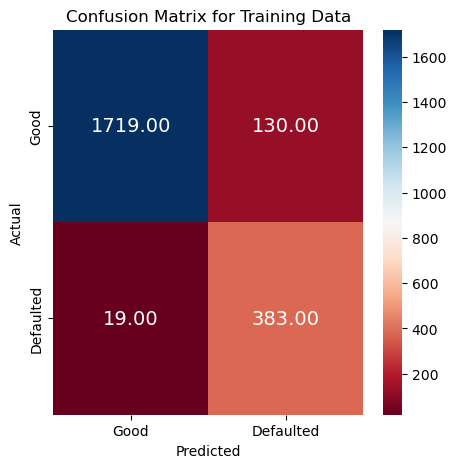

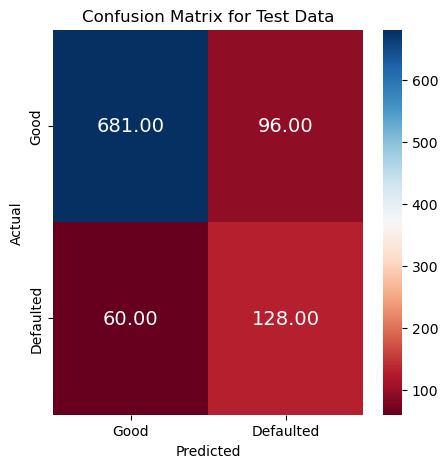

In [51]:
recall_matrix(final_DT, X_train, X_test, y_train, y_test)

**Observations** 
1. This model is giving the best results so far at about 82% for class 1, and the best results as well for class 0(good loans)
2. This means that this model thus far is doing a balanced job, but we still need to keep pushing it to get a better score for identifying defaulting loans
3. This model predicted 154 clients correctly vs the previous models at 149 and 138

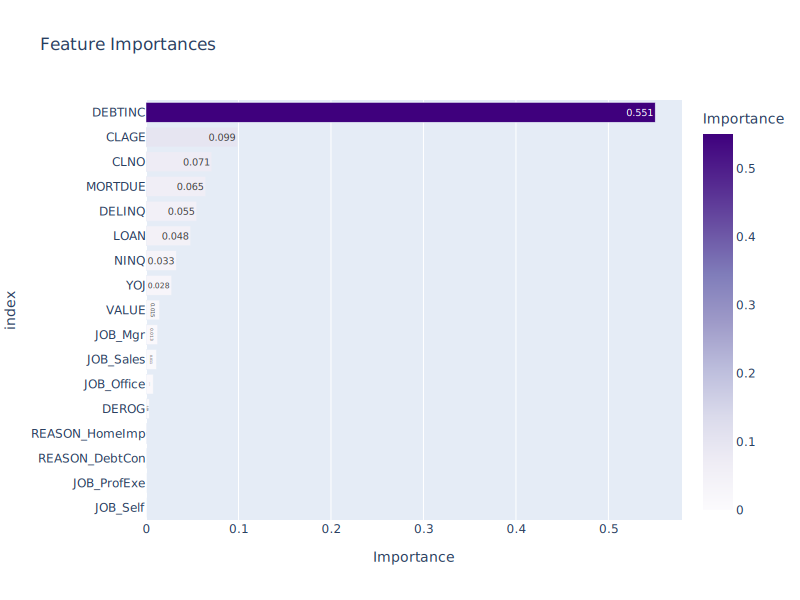

In [53]:
plot_feature_importance(final_DT, X_train)

**Observations:**
1. The tuned model is giving the an overwhelming importance to just 1 variable: Debt to income ratio at about 0.73 while the others are at about 0.1 or less 
2. The model has a high bias, as it has over-simplified the problem and is not capturing the patterns associated with other variable
3. According to this model `Debt to income ratio`, `Age of oldest credit line`, and `Loan amount` are the 3 most important features that describe why a client is defaulting which suggests if a client's DEBTINC is high and their loan amount is also higher than usual, it would take them a long time to pay it off, but I'm not sure why age of the oldest credit line is playing an important part. 

## Visualizing the tuned-decision tree

**Let's plot the tree** and check if the assumptions about DEBTINC. We are only visualizing the tree up to 4 levels.

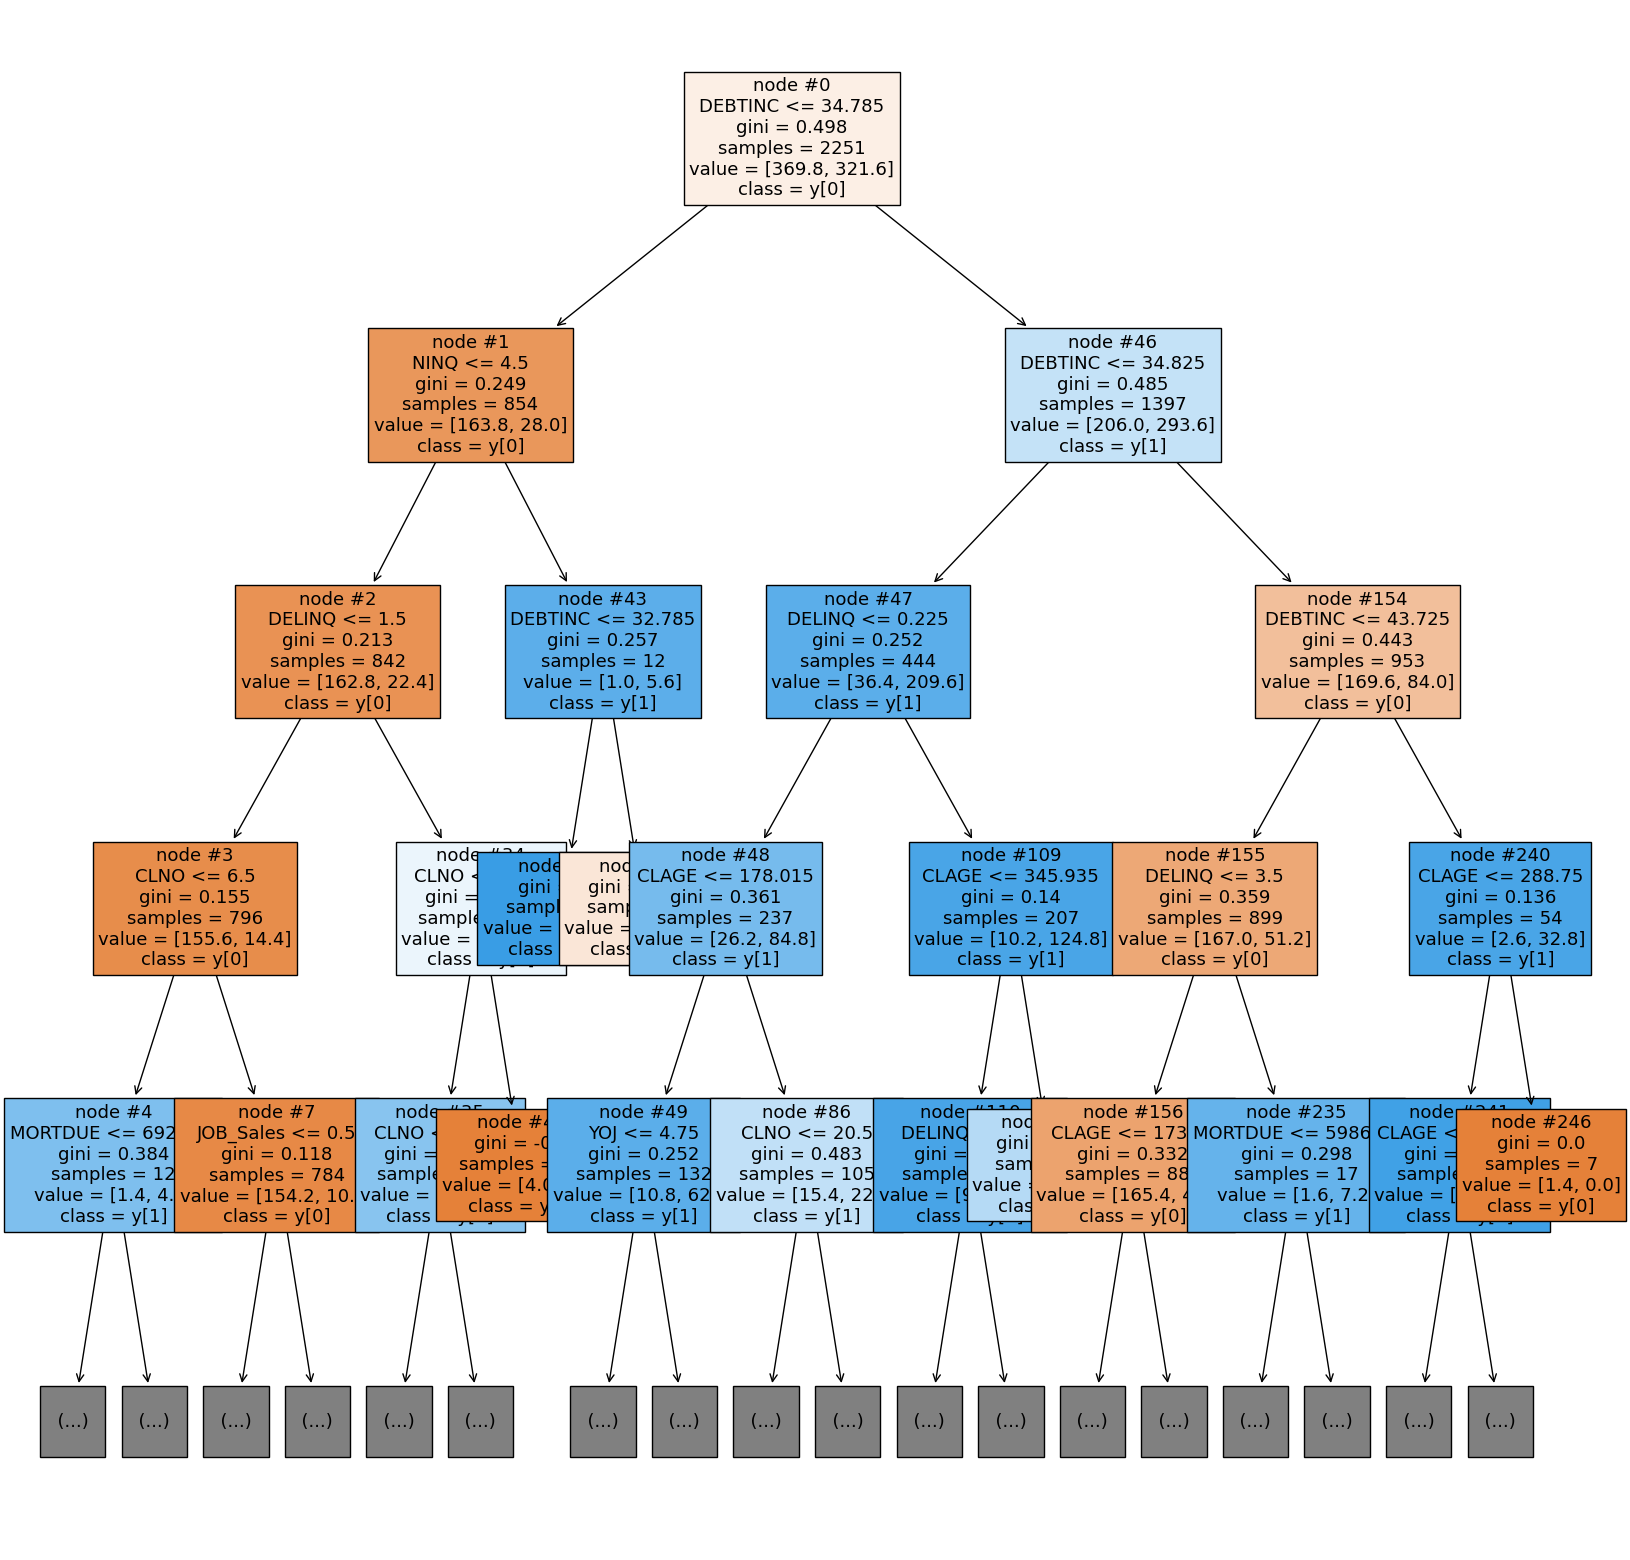

In [57]:
features = list(X.columns)

plt.figure(figsize = (20, 20))

tree.plot_tree(final_DT,
               max_depth = 4,
               feature_names = features, 
               filled = True, fontsize = 13,
               node_ids = True, 
               class_names = True)

plt.show()

**Note:** Blue leaves represent the defaulted loans, while the orange leaves represent the paid loans. Also, the darker the leaf, the higer the number of observations

**Observations:** 

1. To start, it's debt to income ratio then splits off into number of recent inquiries and then further into number of credit lines and age of oldest credit line
2. It seems like the categorical variables such a person's job and their reasons for taking a loan are not important in deciding the split

#### using XG Boost to see if we can get better performance

In [60]:
import xgboost as xgb

# Create an instance of XGBClassifier
xgb_model = xgb.XGBClassifier()

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_model.predict(X_test)

recall score on training set for 0:  1.0
recall score on training set for 1:  1.0
recall score on test set for 0:  0.979
recall score on test set for 1:  0.676


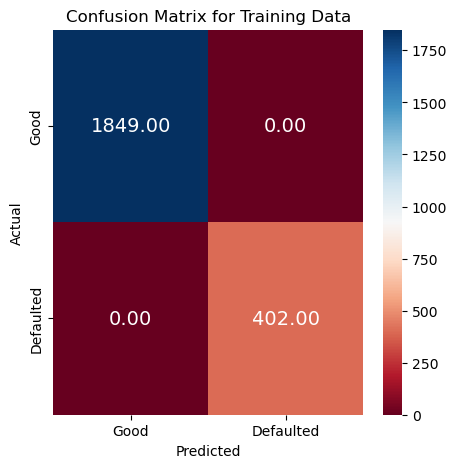

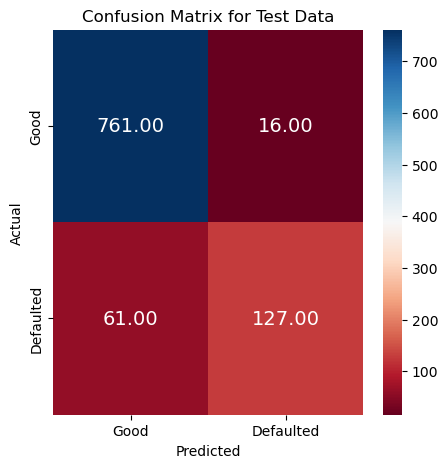

In [61]:
recall_matrix(xgb_model, X_train, X_test, y_train, y_test)

Let's tune the hyperparameters for one final push! 

In [63]:
finalXG = xgb.XGBClassifier()

parameters = {'max_depth': [3, 4, 5, 6],
              'learning_rate': [0.01, 0.1, 0.5],
              'n_estimators': [50, 100, 200]}

xgb_grid_search = GridSearchCV(estimator=finalXG, param_grid=parameters, scoring='recall', cv=10)
xgb_grid_search.fit(X_train, y_train)

final_XG = xgb_grid_search.best_estimator_
print(xgb_grid_search.best_params_)


{'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 200}


In [64]:
y_pred = final_XG.predict(X_test)

recall score on training set for 0:  1.0
recall score on training set for 1:  1.0
recall score on test set for 0:  0.981
recall score on test set for 1:  0.686


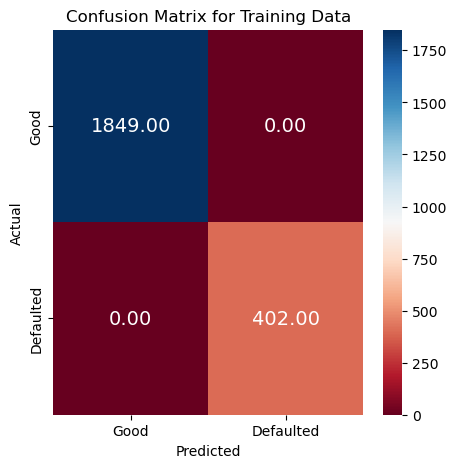

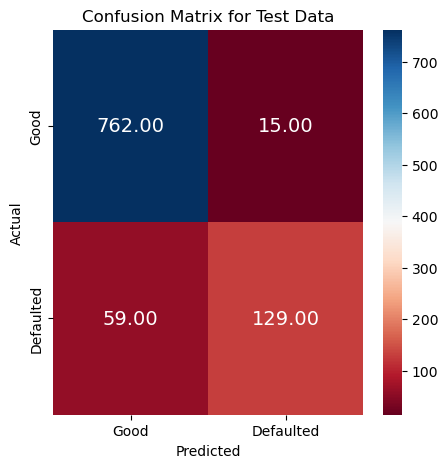

In [65]:
recall_matrix(final_XG, X_train, X_test, y_train, y_test)

**Observations**
1. Seems like XG boost did not do as well as expected even after tuning the hyperparameters using gridsearch

#### Building a Random Forest Classifier

In [68]:
rf = RFC(random_state = 7)

rf = rf.fit(X_train, y_train)

recall score on training set for 0:  1.0
recall score on training set for 1:  1.0
recall score on test set for 0:  0.994
recall score on test set for 1:  0.622


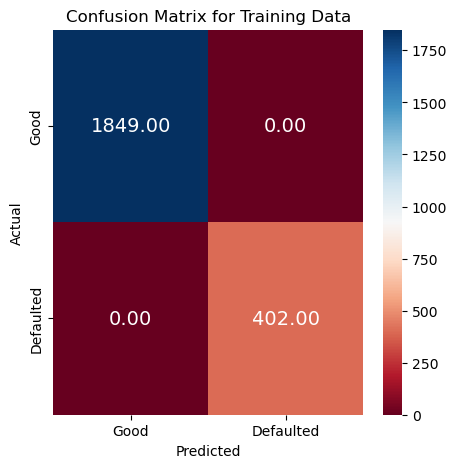

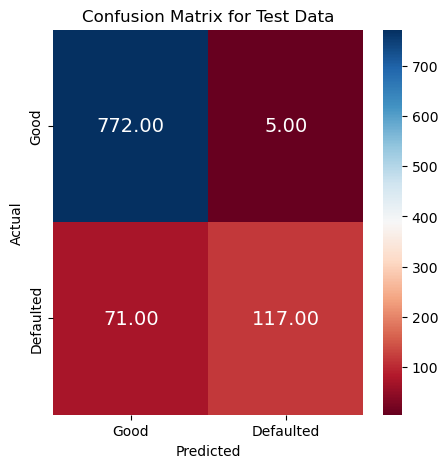

In [69]:
recall_matrix(rf, X_train, X_test, y_train, y_test)

**Observations**
1. Similar initial performance to the decision tree base model where the data is over-fitted to the training data 
2. Similar to the DT, it's doing a great job on true negatives, but poor on the true positives

### **Random Forest Classifier Hyperparameter Tuning**

In [72]:
tuned_rf = RFC(criterion = "entropy", random_state = 7)

parameters = {"n_estimators": [110, 120],
    "max_depth": [6, 7],
    "min_samples_leaf": [20, 25],
    "max_features": [0.8, 0.9],
    "max_samples": [0.9, 1],
    "class_weight": [{0: 0.3, 1: 0.7}]}

scorer = metrics.make_scorer(recall_score, pos_label = 1)

grid_obj = GridSearchCV(tuned_rf, parameters, scoring = scorer, cv = 10)

grid_obj = grid_obj.fit(X_train, y_train)

grid_cv_tuned = grid_obj.best_estimator_

cv_tuned_rf = grid_cv_tuned.fit(X_train, y_train)

print(grid_obj.best_params_)

{'class_weight': {0: 0.3, 1: 0.7}, 'max_depth': 6, 'max_features': 0.8, 'max_samples': 0.9, 'min_samples_leaf': 25, 'n_estimators': 110}


recall score on training set for 0:  0.928
recall score on training set for 1:  0.731
recall score on test set for 0:  0.909
recall score on test set for 1:  0.713


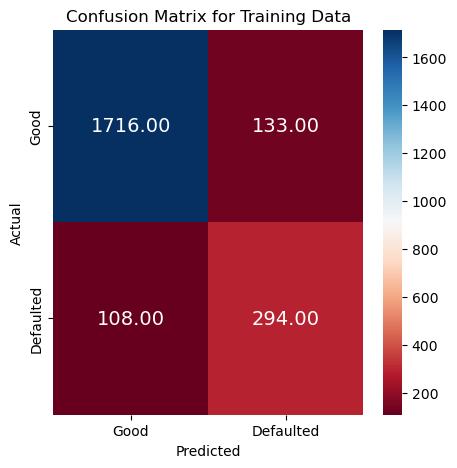

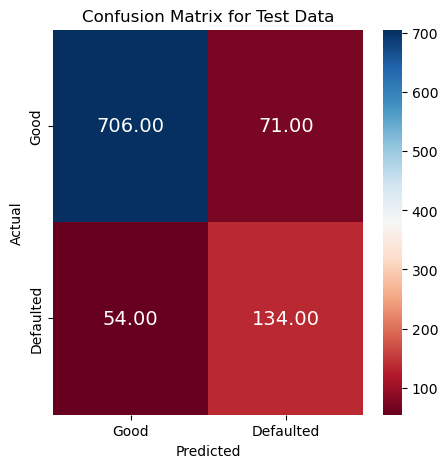

In [73]:
recall_matrix(cv_tuned_rf, X_train, X_test, y_train, y_test)

**Observations**
1. So the model isn't overfitting like the base logistic regression and decision tree models but the performance is not better or different from the tuned Decision tree model
2. The training model is giving the same recall score for the test data so this is a good sign

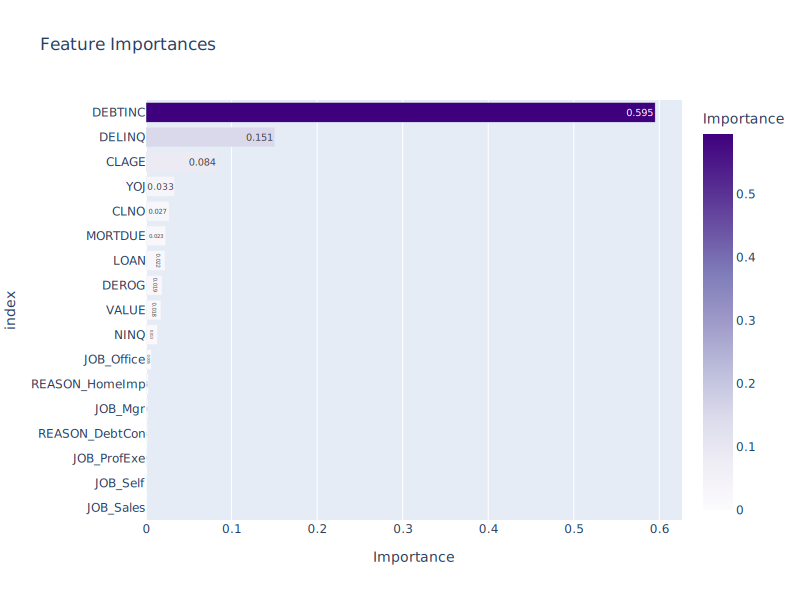

In [75]:
plot_feature_importance(cv_tuned_rf, X_train)

**Observations**
1. This tuned RF is giving less importance to DEBTINC, but still # of delinquent credit lines, and age of oldest credit line 
2. I wonder if I would get better performance by deleting some features such as the JOB category...

**Executive summary**

* Global Bank must balance risk mitigation (minimizing defaults) with income generation (loan approvals).  The Tuned DT 1 decision tree model optimizes this balance, prioritizing accurate default prediction.
* The model emphasizes credit-related features (derogatory reports, delinquent lines) for its predictions, while also considering client occupation and debt-to-income ratios.

**Key Insights**

* Clients who default (DL) and those who repay (GL) may have similar debt levels and occupations.
* Credit history (derogatory reports, delinquencies) is the strongest differentiating factor for model predictions. 


**Solution Design and Recommendations**

The Tuned DT 1 model effectively balances the need to approve proftable loans (GL) and minimize defaults (DL). By prioritizing recall, it achieves an 85% accuracy rate in identifying DLs, aiding Global Bank in risk reduction. Here are key recommendations for implementation and refinement:

* **Prioritize Accurate Data:** Ensure precise collection and calculation of debt-to-income ratios, the model's most significant feature.
* **Enhance Client Profiles:** Refine categorical data on job types, loan purposes, and expand to include credit scores and employment history for more robust client risk assessment.
* **Explore Credit-Focused Data:** Consider creating a separate dataset dedicated to credit-related variables, potentially improving prediction accuracy.
* **Stakeholder Awareness:** Emphasize that the model's reliability is influenced by the availability of comprehensive client data, including total income, industry, and external debt obligations. 
ations.